[Reference: Novel indexes for diagnosing metabolic syndrome in apparently healthy Gujarati Asian Indians: a cross-sectional study](https://academic.oup.com/qjmed/article/109/11/717/2631720?login=false)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import pandas as pd

In [2]:
def compute_z_score(x, params):
    return (x-params[0])/params[1]

In [3]:
def compute_percentiles(func, params, patient_details, plabel, nlabel, visualise, savefig):
    
    score = func(patient_details)
    sex = patient_details['sex']
    percentiles = [norm.cdf(score, params[sex][x][0], params[sex][x][1])*100 for x in ['MetSN', 'MetSP']]
    
    if(visualise):
        metsn_params = params[sex]['MetSN']
        metsp_params = params[sex]['MetSP']
                
        plt.figure(figsize=(14,5))
        
        ### Fix the axis to [-4,4]
        z_score = compute_z_score(score, metsn_params)
        # Bound the z_score values to be between -4 to 4
        if(z_score>4): z_score = 4
        elif(z_score<-4): z_score = -4
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
#         r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-4, 4, 100)
        y1 = norm.pdf(x1, 0,1)
        
        plt.subplot(1,2,1)
        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(plabel)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-4,5)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        z_score = compute_z_score(score, metsp_params)
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-4, 4, 100)
        y1 = norm.pdf(x1, 0,1)
        
        plt.subplot(1,2,2)
        plt.plot(x1, y1, color='red')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(nlabel)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-4,5)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
                
        if(savefig): plt.savefig(f"./Patients/{patient_details['id']}/{patient_details['id']}_{func.__name__}.png")
        plt.show()
        
    return score, percentiles

# LAP / Obesity

#### Formulae

Males: (WC (cm) - 65) × (TG (mmol/l))

Females: (WC (cm) - 58) × (TG (mmol/l))

In [4]:
LAP_params = {
                    'M': {'MetSN': [16.48, 10.95], 'MetSP': [36.11, 19.9]},
                    'F': {'MetSN': [16.01, 10.14], 'MetSP': [34.69, 19.34]}
            }

In [5]:
# wc(cm), TG(mg/dl)
def LAP(patient):
    sex, WC , TG = patient['sex'], patient['WC'], patient['TG']
    if (sex == 'M'):
        return min(100,((WC-65)*(TG/88.57))*(100/160))
    elif (sex == 'F'):
        return min(100,((WC-58)*(TG/88.57))*(100/160))

In [6]:
def scale_LAP(Ob_score):
    if(Ob_score <= 17): return 1.4706*Ob_score
    elif(Ob_score <= 29): return 2.0833*Ob_score - 10.417
    elif(Ob_score <= 44): return 1.6667*Ob_score + 1.6667
    else: return 0.4464*Ob_score + 55.357

# VAI / Metabolic Syndrome

### Formulae

**Males:** VAI=(WC/(39.69+(1.88×BMI)))×(TG/0.03)×(1.31/HDL)

**Females:** VAI(WC/(36.58+(1.89×BMI)))×(TG/0.81)×(1.52/HDL)

In [7]:
VAI_params = {
                    'M': {'MetSN': [14.59, 2.35], 'MetSP': [30.82, 18.24]},
                    'F': {'MetSN': [15.18, 4.71], 'MetSP': [31.53, 21.18]}
            }

In [8]:
# WC(cm), BMI(kg/m2), TG(mmol/L), HDL(mmol/L)
def VAI(patient):
    sex, WC, BMI, TG, HDL = patient['sex'], patient['WC'], patient['BMI'], patient['TG'], patient['HDL']
    if (sex == 'M'):
        return min(100,((WC/(39.69+(1.88*BMI)))*(TG/(88.57*1.03))*((1.31*38.67)/HDL))*(100/8.5))
    elif (sex == 'F'):
        return min(100,((WC/(36.58+(1.89*BMI)))*(TG/(88.57*0.81))*((1.52*38.67)/HDL))*(100/8.5))

In [9]:
def scale_VAI(MS_score):
    if(MS_score <= 15): return 1.6667*MS_score
    elif(MS_score <= 24): return 2.7778*MS_score - 16.667
    elif(MS_score <= 38): return 1.7857*MS_score + 7.1429
    else: return 0.4032*MS_score + 59.677

# Diabetes Score 1

In [10]:
Diabetes1_params = {
                    'M': {'MetSN': [17.79, 5.86], 'MetSP': [46.4, 17.86]},
                    'F': {'MetSN': [17.79, 5.86], 'MetSP': [46.4, 17.86]}
            }

In [11]:
def compute_age_factor_A(BMI, age):
    if(BMI > 40 or BMI < 18.5): return 0 # WHAT TO DO IN THIS CASE?
    if(BMI>=38): return -0.0002409*(age**3) +0.035989*(age**2)-1.2938*age +15.9448
    elif(BMI>=36): return -0.00018165*(age**3) +0.026829*(age**2)-0.88434*age +9.7043
    elif(BMI>=34): return -9.02e-05*(age**3) +0.014945*(age**2)-0.44345*age +4.9542
    elif(BMI>=32): return -0.00015453*(age**3) +0.024283*(age**2)-0.89484*age +10.4953
    elif(BMI>=30): return -0.00014778*(age**3) +0.023199*(age**2)-0.88224*age +10.346
    elif(BMI>=28): return -0.0001085*(age**3) +0.017384*(age**2)-0.6534*age +7.1327
    elif(BMI>=26): return -6.576e-05*(age**3) +0.011355*(age**2)-0.44233*age +5.225
    elif(BMI>=24): return -3.9578e-05*(age**3) +0.0075099*(age**2)-0.31027*age +3.7777
    elif(BMI>=22): return -1.5022e-05*(age**3) +0.0038618*(age**2)-0.16786*age +2.0549
    elif(BMI>=20): return 0.0016166*(age**2)-0.089607*age +1.2032
    elif(BMI>=18.5): return 0.00093971*(age**2)-0.042102*age +0.57713

In [12]:
def Diabetes1(patient):
    sex, age, glu, TG, BMI = patient['sex'], patient['age'], patient['glucose'], patient['TG'], patient['BMI']
    age_factor = compute_age_factor_A(BMI, age)
    return (math.log((1+((glu/80)*(TG/80)*(BMI/22)))*(1+(age_factor/100))))*25

In [13]:
def scale_Diabetes(Db_score):
    if(Db_score <= 18): return 1.3889*Db_score
    elif(Db_score <= 40): return 1.1364*Db_score + 4.5455
    elif(Db_score <= 54): return 1.7857*Db_score - 21.429
    else: return 0.5435*Db_score + 45.652

# Diabetes Score 2

In [14]:
Diabetes2_params = {
                    'M': {'MetSN': [17.03, 7.52], 'MetSP': [42.89, 13.21]},
                    'F': {'MetSN': [17.03, 7.52], 'MetSP': [42.89, 13.21]}
            }

In [15]:
def compute_age_factor_B(BMI):
    if(BMI > 40 or BMI < 18.5): return 0 # WHAT TO DO IN THIS CASE?
    if(BMI>=38): return 19.74
    elif(BMI>=36): return 17.75
    elif(BMI>=34): return 20.28
    elif(BMI>=32): return 15.21
    elif(BMI>=30): return 12.58
    elif(BMI>=28): return 10.62
    elif(BMI>=26): return 9.44
    elif(BMI>=24): return 7.75
    elif(BMI>=22): return 7.11
    elif(BMI>=20): return 6.02
    elif(BMI>=18.5): return 4.27

In [16]:
def Diabetes2(patient):
    sex, age, glu, TG, BMI = patient['sex'],patient['age'],patient['glu'],patient['TG'],patient['BMI']
    age_factor_A = compute_age_factor_A(BMI, age)
    age_factor_B = compute_age_factor_B(BMI)
    age_factor = (age_factor_A/age_factor_B)/10
    return 6.6667*((math.log(glu*TG/2))*(1+BMI/40)*(1+age_factor))-66.667

# NAFLD

In [17]:
NAFLD_params = {
                    'M': {'MetSN': [30.16,18.29], 'MetSP': [60.55,20.94]},
                    'F': {'MetSN': [30.16,18.29], 'MetSP': [60.55,20.94]}
            }

In [18]:
def TG_factor_score(TG):
    if(TG>300): return 3
    elif(TG>80): return 0.013636*TG-1.0909
    else: return 0

def HOMA_IR_factor_score(HOMA_IR):
    if(HOMA_IR>6): return 3
    elif(HOMA_IR>0.5): return 0.54545*HOMA_IR-0.27273
    else: return 0

def GGT_factor_score(GGT):
    if(GGT>60): return 3
    elif(GGT>20): return 0.075*GGT-1.5
    else: return 0

def ALT_AST_factor_score(ALT_AST):
    if(ALT_AST>1.5): return 3
    elif(ALT_AST>0.95): return 5.4545*ALT_AST-5.1818
    else: return 0

def Uric_acid_factor_score(Uric_acid):
    if(Uric_acid>7.6): return 3
    elif(Uric_acid>4.2): return 0.8824*Uric_acid- 3.7059
    else: return 0

In [19]:
def evaluate_FLI(patient):
    WC, BMI, glucose, insulin, TG, GGT, ALT, AST, Uric_acid = patient['WC'],patient['BMI'],patient['glucose'],patient['insulin'],patient['TG'],patient['GGT'],patient['ALT'],patient['AST'],patient['Uric_acid']
    
    val = 0.953*math.log(TG)+0.139*BMI+0.718*math.log(GGT)+0.053*WC-15.745
    return 100*(math.exp(val)/(1+math.exp(val)))

In [20]:
def evaluate_NRS(patient):
    WC, BMI, glucose, insulin, TG, GGT, ALT, AST, Uric_acid = patient['WC'],patient['BMI'],patient['glucose'],patient['insulin'],patient['TG'],patient['GGT'],patient['ALT'],patient['AST'],patient['Uric_acid']
    NRS_TG = TG_factor_score(TG)
    HOMA_IR = (glucose*0.0555)*(insulin/22.5)
    NRS_HOMA_IR = HOMA_IR_factor_score(HOMA_IR)
    NRS_GGT = GGT_factor_score(GGT)
    NRS_ALT_AST = ALT_AST_factor_score(ALT/AST)
    NRS_Uric_acid = Uric_acid_factor_score(Uric_acid) #Uric acid not multiplied by 59.48
    
    count = 0
    for i in [NRS_TG, NRS_HOMA_IR, NRS_GGT, NRS_ALT_AST, NRS_Uric_acid]:
        if i<= 0.5: count += 1
    if(count >=4): frequency_factor = 0.8
    elif(count==3): frequency_factor = 1
    elif(count==2): frequency_factor = 1.1
    else: frequency_factor = 1.2
        
    NRS = (NRS_TG + 1.5*NRS_HOMA_IR + 1.5*NRS_GGT + 2*NRS_ALT_AST + NRS_Uric_acid)*(100/21)*frequency_factor
    
    return NRS   

In [21]:
def NAFLD(patient):    
    NRS = evaluate_NRS(patient)
    FLI = evaluate_FLI(patient)
    return (FLI*0.6+NRS)/1.6

In [22]:
def scale_NAFLD(NAFLD_score):
    if(NAFLD_score <= 31): return 0.8065*NAFLD_score
    elif(NAFLD_score <= 75): return 1.1364*NAFLD_score - 10.227
    else: return NAFLD_score

# Cardiac Risk Score

In [23]:
Cardiac_params = {
    'M': {'MetSN': [21.36,13.94], 'MetSP': [57.98,18.31]},
    'F': {'MetSN': [21.36,13.94], 'MetSP': [57.98,18.31]}
}

In [24]:
def evaluate_framingham_score(patient):
    if(patient['sex'] =='F'):
        age,TC, smoker = patient['age'], patient['TC'], patient['smoking']
        HDL,SBP = patient['HDL'], patient['SBP']
        score = 0

        age_scores = [-7,-7,-7,-3,0,3,6,8,10,12,14,16]
        score += age_scores[int(age/5) - 4]
        
        cholesterol_score = [[0,4,8,11,13],[0,4,8,11,13],[0,3,6,8,10],[0,2,4,5,7],[0,1,2,3,4],[0,1,1,2,2]]
        if(TC<160): score += cholesterol_score[int(age/10) - 2,0]
        elif(TC<=199): score += cholesterol_score[int(age/10) - 2][1]
        elif(TC<=239): score += cholesterol_score[int(age/10) - 2][2]
        elif(TC<=279): score += cholesterol_score[int(age/10) - 2][3]
        else: score += cholesterol_score[int(age/10) - 2][4]
        
        smoke_score = [9,9,7,4,2,1]
        if(smoker): score += smoker_score[int(age/10) - 2]

        
        if(HDL >= 60): score -= 1
        elif(HDL >= 50): score = score
        elif(HDL >= 40): score += 1
        else: score += 2

        sbp_score = [[0,1,2,3,3,4],[0,3,4,5,5,6]]
        sbp = int(SBP/10)-11
        if(sbp<0): sbp = 0
        if(sbp>4): sbp = 4

        if(patient['antihypertension_drugs']==1): 
            score += sbp_score[1][sbp]
        else: 
            score += sbp_score[0][sbp]
            
        score_risk={9:1,10:1,11:1,12:1,13:2,14:2,15:3,16:4,17:5,18:6,19:8,20:11,
                   21:14,22:17,23:22,24:27}
        
        if(score<9): return 0
        elif(score<=24): return score_risk[score]
        else: return 30
        
    elif(patient['sex'] == 'M'):
        age,TC, smoker = patient['age'], patient['TC'], patient['smoking']
        HDL,SBP = patient['HDL'], patient['SBP']
        score = 0

        age_scores = [-9,-9,-9,4,0,3,6,8,10,11,12,13]
        score += age_scores[int(age/5) - 4]

        cholesterol_score = [[0,4,7,9,11],[0,4,7,9,11],[0,3,5,6,8],[0,2,3,4,5],[0,1,1,2,3],[0,0,0,1,1]]
        if(TC<160): score += cholesterol_score[int(age/10) - 2][0]
        elif(TC<=199): score += cholesterol_score[int(age/10) - 2][1]
        elif(TC<=239): score += cholesterol_score[int(age/10) - 2][2]
        elif(TC<=279): score += cholesterol_score[int(age/10) - 2][3]
        else: score += cholesterol_score[int(age/10) -2][4]

        smoke_score = [8,8,5,3,1,1]
        if(smoker): score += smoker_score[int(age/10) - 2]

        if(HDL >= 60): score -= 1
        elif(HDL >= 50): score = score
        elif(HDL >= 40): score += 1
        else: score += 2

        sbp_score = [[0,0,1,1,1,2],[0,1,2,2,2,3]]
        sbp = int(SBP/10)-12
        if(sbp<0): sbp = 0
        if(sbp>4): sbp = 4
        
        if(patient['antihypertension_drugs']): score += sbp_score[1][age]
        else: score += sbp_score[0][sbp]
            
        score_risk = {0:0,1:1,2:1,3:1,4:1,5:2,6:2,7:3,8:4,9:5,10:6,11:8,12:10,13:12
                     ,14:16,15:20,16:25}
    
        if(score<17): return score_risk[score]
        else: return 30

        return score

In [25]:
def Cardiac(patient):
    
    monocytes_count = patient['monocytes']*patient['WBC']/100
    MHR = 1000*monocytes_count/patient['HDL']
    PLkR = patient['platelets']/patient['WBC']
    PMR = patient['platelets']/monocytes_count
    Framingham_score = evaluate_framingham_score(patient)
#     print(Framingham_score, monocytes_count, MHR, PLkR, PMR)
    
    return min(100,(100/5.2)*math.log(1+(max(0.5,Framingham_score/2))*(MHR/5)*(38/PLkR)*(690/PMR)))

In [26]:
def scale_Cardiac(CRS):
    if(CRS <= 21): return 1.1905*CRS
    elif(CRS <= 51): return 0.8333*CRS + 7.5
    elif(CRS <= 65): return 1.7857*CRS - 41.071
    else: return 0.7143*CRS + 28.571

# Dyslipidemia

In [27]:
def Dyslipidemia(patient, visualise = True, savefig = False):
    TG, TC, HDL, LDL, patient_id = patient['TG'],patient['TC'],patient['HDL'],patient['LDL'], patient['id']
    score = min((math.log(1+((TG/80)*(TC/150)*(LDL/80)*(50/HDL))))*(100/3), 100)
    
    
    if(visualise):
        z_score = compute_z_score(score, [38,18])
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-r, r, r*100)
        y1 = norm.pdf(x1, 0,1)

        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(f"Dyslipidemia Score Distribution")
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        if(savefig): plt.savefig(f'./Patients/{patient_id}/{patient_id}_Dyslipidemia.png')
        plt.show()
    return score

In [28]:
def scale_Dyslipidemia(DS_score):
    if(DS_score <= 9): return 2.7778*DS_score
    elif(DS_score <= 32): return 1.087*DS_score + 15.217
    elif(DS_score <= 45): return 1.9231*DS_score - 11.538
    else: return 0.4545*DS_score + 54.545

# Hypertension Score

In [29]:
def age_gender_effect(sex, age):
    if(sex == 'M'): return 1+0.25*((0.7304*age+3.6894)/100)
    else: return 1+0.25*((0.9452*age-12.971)/100)
    
def uric_acid_effect(sex, Uric_acid):
    if(sex == 'M' or (sex == 'F' and Uric_acid*59.48 <= 339)): return 1
    else: return 1+0.5*((0.0541*Uric_acid - 10.811)/100)

In [30]:
def Hypertension(patient):
    sex, age, Uric_acid, SBP, DBP = patient['sex'], patient['age'], patient['Uric_acid'], patient['SBP'], patient['DBP']
    MAP = (SBP+2*DBP)/3
    Anthro_effect = age_gender_effect(sex, age)*uric_acid_effect(sex, Uric_acid)
    
    return 90.909*((MAP/73)*Anthro_effect -1)

In [31]:
def obtain_SBP_params(sex, age):
    if(sex == 'M'):
        if(age>=75): return [137.2,21.4]
        elif(age>=65): return [136.5, 20.4]
        elif(age>=55): return [134.1, 19.5]
        elif(age>=45): return [130.2, 18.2]
        elif(age>=20): return [124.1, 15.1]
        elif(age>=18): return [121.4, 15]
    elif(sex == 'F'):
        if(age>=75): return [136, 22.7]
        elif(age>=65): return [136, 21.2]
        elif(age>=55): return [132.4, 19.3]
        elif(age>=45): return [126.7, 18]
        elif(age>=20): return [115.6, 15]
        elif(age>=18): return [111.4, 12.4]

In [32]:
def obtain_DBP_params(sex, age):
    if(sex == 'M'):
        if(age>=75): return [80.1, 12.4]
        elif(age>=65): return [81.8, 11.9]
        elif(age>=55): return [82.9, 11.6]
        elif(age>=45): return [83.2, 11.7]
        elif(age>=20): return [79.6, 10.9]
        elif(age>=18): return [78.4, 11]
    elif(sex=='F'):
        if(age>=75): return [80.6, 12.9]
        elif(age>=65): return [80.8, 11.9]
        elif(age>=55): return [81.1, 11]
        elif(age>=45): return [80.3, 10.9]
        elif(age>=20): return [75.1, 10.4]
        elif(age>=18): return [71.9, 9.6]

In [33]:
def plot_distributions(patient_id,savefig, z_score1,  title1, z_score2=-1, title2='None'):
    
    plt.figure(figsize=(14,5))

    z_score = z_score1
    x = [z_score]*2
    y = [0, norm.pdf(z_score, 0, 1)]
    r = max(3, math.ceil(abs(z_score)))
    x1 = np.linspace(-r, r, r*100)
    y1 = norm.pdf(x1, 0,1)
    
    if not(z_score == -1):
        plt.subplot(1,2,1)
    plt.plot(x1, y1, color='blue')
    plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
    plt.title(title1)
    plt.xlabel("Z-score")
    plt.xticks([x for x in range(-r,r+1)])
    if z_score < 0:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
    else:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
    plt.ylim(0, norm.pdf(0,0,1)*1.15)

    z_score = z_score2
    x = [z_score]*2
    y = [0, norm.pdf(z_score, 0, 1)]
    r = max(3, math.ceil(abs(z_score)))
    x1 = np.linspace(-r, r, r*100)
    y1 = norm.pdf(x1, 0,1)
    
    if not(z_score == -1):
        plt.subplot(1,2,2)
        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(title2)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)

    if(savefig):
        if(z_score2 == -1): plt.savefig(f'./Patients/{patient_id}/{patient_id}_TSH.png')
        else: plt.savefig(f'./Patients/{patient_id}/{patient_id}_SBP-DBP.png')
    plt.show()

In [34]:
def plot_SBP_DBP_distribution(patient, savefig):
    
    sex, age, SBP, DBP, patient_id = patient['sex'],patient['age'],patient['SBP'],patient['DBP'], patient['id']
    
    if(age>=75): age_grp = ">=75"
    elif(age>=65): age_grp = "65-74"
    elif(age>=55): age_grp = "55-64"
    elif(age>=45): age_grp = "45-54"
    elif(age>=20): age_grp = "20-44"
    elif(age>=18): age_grp = "18-19"

    z_score1 = compute_z_score(SBP, obtain_SBP_params(sex, age))
    title1 = f"SBP Distribution, Age: {age_grp}, {sex}"
    z_score2 = compute_z_score(DBP, obtain_DBP_params(sex, age))
    title2 = f"DBP Distribution, Age: {age_grp}, {sex}"
    plot_distributions(patient_id, savefig, z_score1, title1, z_score2, title2)

## Hypothyroidism Score

In [35]:
def Hypothyroidism(patient):
    Diabetes_score_1 = Diabetes1(patient)
    Dyslipidemia_score = Dyslipidemia(patient, False)
    sex, TSH = patient['sex'], patient['TSH']
    if(sex == 'M'):
        return (TSH*(1+0.25*(Diabetes_score_1/100)+0.25*(Dyslipidemia_score/100)))*(100/27)
    if(sex == 'F'):
        return (TSH*(1+0.25*(Diabetes_score_1/100)+0.25*(Dyslipidemia_score/100)))*(100/34)

In [36]:
def plot_TSH_distribution(patient, savefig):
    
    sex, TSH, patient_id = patient['sex'],patient['TSH'], patient['id']
    if(sex == 'M'):
        z_score1 = compute_z_score(TSH, [9.75,6.58])
    else:
        z_score1 = compute_z_score(TSH, [11.46,8.36])
    title1 = f"TSH Distribution ({sex})"
    plot_distributions(patient_id, savefig, z_score1, title1)

## PCOD Score

In [37]:
def PCOD(patient):
    T, LH, FSH, glucose, insulin = patient['T'], patient['LH'], patient['FSH'], patient['glucose'], patient['insulin']
    LH_FSH = LH/FSH
    HOMA_IR = (glucose*0.0555)*(insulin/22.5)
    print(HOMA_IR, LH_FSH, T)
    pcod_score = min(100,math.log((T/1.42)*((LH_FSH*LH_FSH)/0.025)*(1+(0.25*(HOMA_IR/1.5))))*(100/11.5))
    return pcod_score

In [38]:
PCOD_params = {
    'F': {'MetSN': [55.8, 8.96], 'MetSP': [77.42,14.21]}
}

In [39]:
def scale_PCOD(PCOS_score):
    if(PCOS_score <= 56): return 0.4464*PCOS_score
    elif(56 < PCOS_score <= 72): return 1.5625*PCOS_score - 62.5
    elif(72 < PCOS_score <= 83): return 2.2727*PCOS_score - 113.64
    else: return 1.4706*PCOS_score - 47.059

## Lifestyle Scoring

In [40]:
class Question():
    def __init__(self, title, options):
        self.title = title
        self.options = options
    
    def get_option(self,marked):
        idx = ord(marked.upper()) - ord('A')
        return self.options[idx]
    
    def get_score(self, marked_option, scores):
        idx = ord(marked_option.upper()) - ord('A')
        return scores[idx]

In [41]:
ques = []
ques.append(Question('Good quality sleep', ['A) Between 7 to 9 hours per night', 'B) Between 5 to 6 hours per night', 'C) ≤4 or ≥9 hours per night']))
ques.append(Question('Sedentary time', ['A) <1 hour per day', 'B) ≥1 and <4 hours per day', 'C) >4 hours per day']))
ques.append(Question('Diet diversity', ['A) >3 food groups per day', 'B) < 3 food groups per day']))
ques.append(Question('Physical activity', ['A) ≥60 mins per day', 'B) ≥30 mins per day', 'C) <30 mins or none per day']))
ques.append(Question('Fruit intake', ['A) 1-2 per day', 'B) ≤2 to 3 times a week', 'C) Once a week or less']))

ques.append(Question('Legume consumption', ['A) Everyday', 'B) Every alternate day', 'C) Not Frequent']))
ques.append(Question('Alcohol consumption', ['A) <3 units/ week', 'B) ≥3 units / week', 'C) Former drinker', 'D) Do not drink']))
ques.append(Question('Cigarette consumption', ['A) ≤2 days a month', 'B) ≥3 and ≤19 days a month', 'C) ≥20 days a month', 'D) Former smoker', 'E) Do not smoke']))

ques.append(Question('Sugary drinks or beverages', ['A) ≤1 per week', 'B) 2-3 per week', 'C) 4-5 per week', 'D) >=6 per week or >=1 per day']))
ques.append(Question('Breakfast frequency', ['A) More than 5 times a week', 'B) Less than 5 times a week', 'C) Do not have breakfast']))

In [42]:
questions = {}
for question in ques:
    questions[question.title] = question

In [43]:
def NAFLD_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Good quality sleep'].get_score(marked['Good quality sleep'][0], [0,1,2])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,2,5])
    score += ques['Diet diversity'].get_score(marked['Diet diversity'][0], [0,2])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,2,5])
    score += ques['Fruit intake'].get_score(marked['Fruit intake'][0], [0,2,5])
    return score*(100/19)

In [44]:
def Hypertension_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Legume consumption'].get_score(marked['Legume consumption'][0], [0,2,5])
    score += ques['Alcohol consumption'].get_score(marked['Alcohol consumption'][0], [2,5,1,0])
    score += ques['Cigarette consumption'].get_score(marked['Cigarette consumption'][0], [0,2,5,1,0])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,1,2])
    score += ques['Diet diversity'].get_score(marked['Diet diversity'][0], [0,2])
    return score*(100/19)

In [45]:
def Diabetes_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Sugary drinks or beverages'].get_score(marked['Sugary drinks or beverages'][0], [0,2,5,5])
    score += ques['Breakfast frequency'].get_score(marked['Breakfast frequency'][0], [0,5,10])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,2,5])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,2,5])
    return score*(100/25)

In [46]:
def Obesity_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Good quality sleep'].get_score(marked['Good quality sleep'][0], [0,1,2])
    score += ques['Breakfast frequency'].get_score(marked['Breakfast frequency'][0], [0,2,4])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,1,2])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,1,2])
    score += ques['Sugary drinks or beverages'].get_score(marked['Sugary drinks or beverages'][0], [0,1,2,2])
    return score*(100/12)

In [47]:
def Metabolic_Syndrome_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Good quality sleep'].get_score(marked['Good quality sleep'][0], [0,1,2])
    score += ques['Breakfast frequency'].get_score(marked['Breakfast frequency'][0], [0,2,2])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,1,2])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,1,2])
    score += ques['Sugary drinks or beverages'].get_score(marked['Sugary drinks or beverages'][0], [0,1,1,2])
    if(patient['sex'] == 'M'): score += 1
        
    BMI = patient['BMI']
    if(17 <= BMI < 25): score += 0
    elif(16<= BMI < 17 or 25<=BMI<30): score += 1
    elif(BMI<16 or 30<=BMI<35): score += 2
    else: score += 3
    
    WHtR = patient['WC']/patient['height']
    score += np.sign(WHtR - 0.5) + 1

    return score*(100/16)

In [48]:
questions

{'Good quality sleep': <__main__.Question at 0x21bfa8cbe80>,
 'Sedentary time': <__main__.Question at 0x21bfa8cb130>,
 'Diet diversity': <__main__.Question at 0x21bfa8cb220>,
 'Physical activity': <__main__.Question at 0x21bfa90d040>,
 'Fruit intake': <__main__.Question at 0x21bfa90d0d0>,
 'Legume consumption': <__main__.Question at 0x21bfa8e6520>,
 'Alcohol consumption': <__main__.Question at 0x21bfa8e6970>,
 'Cigarette consumption': <__main__.Question at 0x21bfa8e6ee0>,
 'Sugary drinks or beverages': <__main__.Question at 0x21bfa8e63a0>,
 'Breakfast frequency': <__main__.Question at 0x21bfa8e6eb0>}

In [49]:
def questions_lifestyle_score(questions):
    marked = {}
    print('Evaluating LifeStyle Scores, Please answer the following questions:')
    for title, question in questions.items():
        prompt = question.title + '\n'
        for option in question.options:
            prompt += option + '\n'
        prompt += 'Your choice: '
        marked[title] = question.get_option(input(prompt))
    return marked

### Final Presentation

In [50]:
import os

def generate_comprehensive_report(patient, questions):
    
    p_id = patient['id']
    
    if not(os.path.exists('./patients')):
        os.mkdir('patients')
    
    try:
        os.mkdir(f'./patients/{p_id}')
    except:
        pass
    
    # Patient Details
    print(f"Patient Details:")
    df = pd.DataFrame(patient.values(), index = patient.keys())
    df.columns = ['Values']
    display(df)
    
    print('*'*50)
    
    # Ask the questionnaire for evaluating lifestyle scores
    marked = questions_lifestyle_score(questions)
    df = pd.DataFrame(marked.values(), index = marked.keys())
    df.columns = ['Marked Choice']
    display(df)
    
    print('*'*50)
    print('*'*50)
    
    print('Comprehensive Report')
    
    savefig = True
    
    print('Risk Assessment for Obesity:')
    LAP_score, LAP_percentiles = compute_percentiles(LAP, LAP_params, patient, 'Healthy Population', 'Diseased Population', False, False)
    print("Actual:", LAP_score)
    print(f'Obesity Score: {round(scale_LAP(LAP_score),2)}')
    print(f'Lifestyle Score: {round(Obesity_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(LAP_percentiles[0], 2)}, Diseased Percentile: {round(LAP_percentiles[1], 2)}')
    print('Obesity Score Distributions:')
    compute_percentiles(LAP, LAP_params, patient, 'Healthy Population', 'Obese Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Metabolic Syndrome:')
    VAI_score, VAI_percentiles = compute_percentiles(VAI, VAI_params, patient, 'Healthy Population', 'Metabolic Syndrome Positive Population', False, False)
    print("Actual:", VAI_score)
    print(f'Metabolic Syndrome Score: {round(scale_VAI(VAI_score),2)}')
    print(f'Lifestyle Score: {round(Metabolic_Syndrome_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(VAI_percentiles[0], 2)}th, Diseased Percentile: {round(VAI_percentiles[1], 2)}th')
    print('Metabolic Syndrome Score Distributions:')
    compute_percentiles(VAI, VAI_params, patient, 'Healthy Population', 'Metabolic Syndrome Positive Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Diabetes I:')
    Diabetes1_score, Diabetes1_percentiles = compute_percentiles(Diabetes1, Diabetes1_params, patient, 'Healthy Population', 'Diabetic Population', False, False)
    print("Actual:", Diabetes1_score)
    print(f'Diabetes1 Score: {round(scale_Diabetes(Diabetes1_score),2)}')
    print(f'Lifestyle Score: {round(Diabetes_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(Diabetes1_percentiles[0], 2)}th, Diseased Percentile: {round(Diabetes1_percentiles[1], 2)}th')
    print('Diabetes(Type I) Score Distributions:')
    compute_percentiles(Diabetes1, Diabetes1_params, patient, 'Healthy Population', 'Diabetic Population', True, savefig)
    
#     print('*'*50)
    
    
#     #### Drop Type II
#     print('Risk Assessment for Diabetes(Type II):')
#     Diabetes2_score, Diabetes2_percentiles = compute_percentiles(Diabetes2, Diabetes2_params, patient, 'Healthy Population', 'Diabetic Population', False, False)
#     print(f'Diabetes2 Score: {round(scale_Diabetes(Diabetes2_score),2)}')
#     print(f'Lifestyle Score: {round(Diabetes2_lifestyle_score(patient, questions, marked),2)}')
#     print(f'Healthy Percentile: {round(Diabetes2_percentiles[0], 2)}th, Diseased Percentile: {round(Diabetes2_percentiles[1], 2)}th')
#     print('Diabetes(Type II) Score Distributions:')
#     compute_percentiles(Diabetes2, Diabetes2_params, patient, 'Healthy Population', 'Diabetic Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for NAFLD:')
    NAFLD_score, NAFLD_percentiles = compute_percentiles(NAFLD, NAFLD_params, patient, 'Healthy Population', 'NAFLD Population', False, False)
    print("Actual:", NAFLD_score)
    print(f'NAFLD Score: {round(scale_NAFLD(NAFLD_score),2)}')
    print(f'Lifestyle Score: {round(NAFLD_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(NAFLD_percentiles[0], 2)}th, Diseased Percentile: {round(NAFLD_percentiles[1], 2)}th')
    print('NAFLD Score Distributions:')
    compute_percentiles(NAFLD, NAFLD_params, patient, 'Healthy Population', 'NAFLD Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Cardiac Disease:')
    Cardiac_score, Cardiac_percentiles = compute_percentiles(Cardiac, Cardiac_params, patient, 'Healthy Population', 'Unhealthy Population', False, False)
    print("Actual:", Cardiac_score)
    print(f'Cardiac Score: {round(scale_Cardiac(Cardiac_score),2)}')
    # Lifestyle score?
    print(f'Healthy Percentile: {round(Cardiac_percentiles[0], 2)}th, Diseased Percentile: {round(Cardiac_percentiles[1], 2)}th')
    print('Cardiac Score Distributions:')
    compute_percentiles(Cardiac, Cardiac_params, patient, 'Healthy Population', 'Unhealthy Population', True, savefig)
    
    
    if(patient['sex'] == 'F'):
        print('*'*50)
        print('Risk Assessment for PCOD:')
        PCOD_score, PCOD_percentiles = compute_percentiles(PCOD, PCOD_params, patient, 'Healthy Population', 'PCOD Population', False, False)
        print("Actual:", PCOD_score)
        print(f'PCOD Score: {round(scale_PCOD(PCOD_score),2)}')
        # Lifestyle ?
        print(f'Healthy Percentile: {round(PCOD_percentiles[0], 2)}th, Diseased Percentile: {round(PCOD_percentiles[1], 2)}th')
        print('PCOD score Distributions:')
        compute_percentiles(PCOD, PCOD_params, patient, 'Healthy Population', 'PCOD Population', True, savefig)
    
    
    print('*'*50)
    
    print('Risk Assessment for Hypertension:')
    Hypertension_score = Hypertension(patient)
    print("Actual:", Hypertension_score)
    print(f'Hypertension Score: {round(Hypertension_score,2)}')
    print(f'Lifestyle Score: {round(Hypertension_lifestyle_score(patient, questions, marked),2)}')
    print('Blood Pressure Distributions:')
    plot_SBP_DBP_distribution(patient, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Dyslipidemia:')
    Dyslipidemia_score = Dyslipidemia(patient, False)
    print("Actual:", Dyslipidemia_score)
    print(f'Dyslipidemia Score: {round(scale_Dyslipidemia(Dyslipidemia_score),2)}')
    # Lifestyle Score?
    print('Dyslipidemia Score Distributions:')
    Dyslipidemia(patient, True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Hypothyroidism:')
    Hypothyroidism_score = Hypothyroidism(patient)
    print("Actual:", Hypothyroidism_score)
    print(f'Hypothyroidism Score: {round(Hypothyroidism_score,2)}')
    # Lifestyle Score?
    print('TSH Level Distributions:')
    plot_TSH_distribution(patient, savefig)
    
    
    
    print('*'*115)
    print('*'*50,'End Of Report','*'*50)
    print('*'*115)

In [51]:
P_II_14 = {
    'id' : 'II-14',
    'sex' :'M',
    'age' : 59,
    'WC': 104,
    'HC' : 99,
    'SBP': 143,
    'DBP': 85,
    'height': 162.9,
    'weight': 79.7,
    'BMI': 30.03,
    'TC': 281,
    'HDL': 32.3,
    'LDL': 174,
    'TG': 568,
    'VLDL': 114,
    'AST': 14,
    'ALT': 14,
    'GGT': 69,
    'glucose': 176,
    'PPBS': 205,
    'insulin': 23,
    'Uric_acid': 7.57,
    'TSH': 17.53,
    'smoking': 0,
    'antihypertension_drugs':0,
    'platelets':75,
    'WBC':7,
    'monocytes':9.29
}

Patient Details:


,Values
id,II-14
sex,M
age,59
WC,104
HC,99
SBP,143
DBP,85
height,162.9
weight,79.7
BMI,30.03


**************************************************
Evaluating LifeStyle Scores, Please answer the following questions:
Good quality sleep
A) Between 7 to 9 hours per night
B) Between 5 to 6 hours per night
C) ≤4 or ≥9 hours per night
Your choice: a
Sedentary time
A) <1 hour per day
B) ≥1 and <4 hours per day
C) >4 hours per day
Your choice: a
Diet diversity
A) >3 food groups per day
B) < 3 food groups per day
Your choice: a
Physical activity
A) ≥60 mins per day
B) ≥30 mins per day
C) <30 mins or none per day
Your choice: a
Fruit intake
A) 1-2 per day
B) ≤2 to 3 times a week
C) Once a week or less
Your choice: a
Legume consumption
A) Everyday
B) Every alternate day
C) Not Frequent
Your choice: a
Alcohol consumption
A) <3 units/ week
B) ≥3 units / week
C) Former drinker
D) Do not drink
Your choice: a
Cigarette consumption
A) ≤2 days a month
B) ≥3 and ≤19 days a month
C) ≥20 days a month
D) Former smoker
E) Do not smoke
Your choice: a
Sugary drinks or beverages
A) ≤1 per week
B) 2-3 per w

,Marked Choice
Good quality sleep,A) Between 7 to 9 hours per night
Sedentary time,A) <1 hour per day
Diet diversity,A) >3 food groups per day
Physical activity,A) ≥60 mins per day
Fruit intake,A) 1-2 per day
Legume consumption,A) Everyday
Alcohol consumption,A) <3 units/ week
Cigarette consumption,A) ≤2 days a month
Sugary drinks or beverages,A) ≤1 per week
Breakfast frequency,A) More than 5 times a week


**************************************************
**************************************************
Comprehensive Report
Risk Assessment for Obesity:
Actual: 100
Obesity Score: 100.0
Lifestyle Score: 0.0
Healthy Percentile: 100.0, Diseased Percentile: 99.93
Obesity Score Distributions:


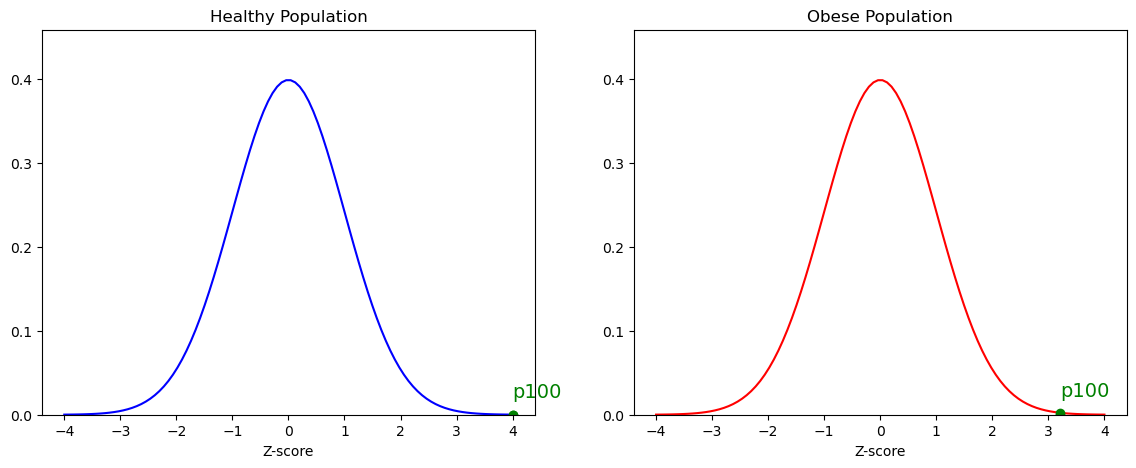

**************************************************
Risk Assessment for Metabolic Syndrome:
Actual: 100
Metabolic Syndrome Score: 100.0
Lifestyle Score: 31.25
Healthy Percentile: 100.0th, Diseased Percentile: 99.99th
Metabolic Syndrome Score Distributions:


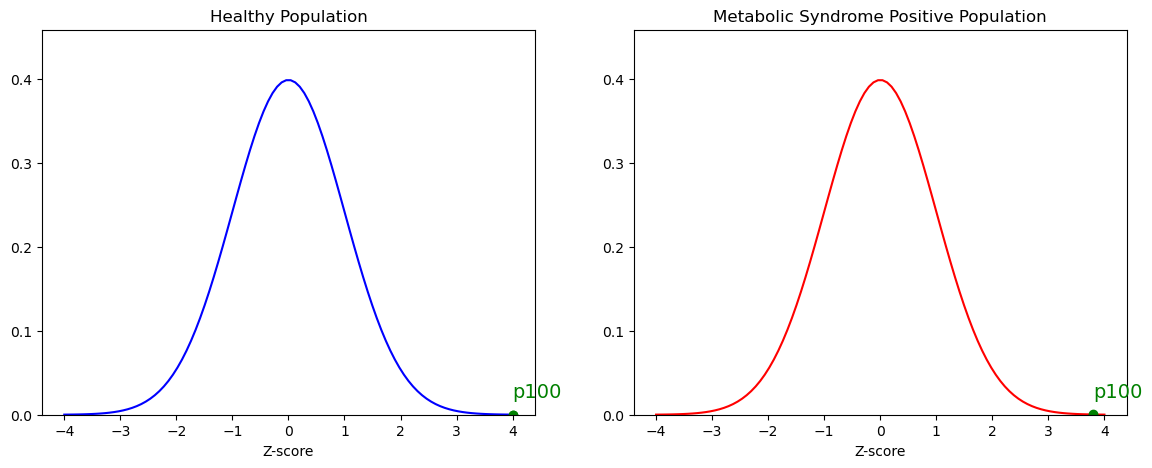

**************************************************
Risk Assessment for Diabetes I:
Actual: 79.72376428998106
Diabetes1 Score: 88.98
Lifestyle Score: 0.0
Healthy Percentile: 100.0th, Diseased Percentile: 96.9th
Diabetes(Type I) Score Distributions:


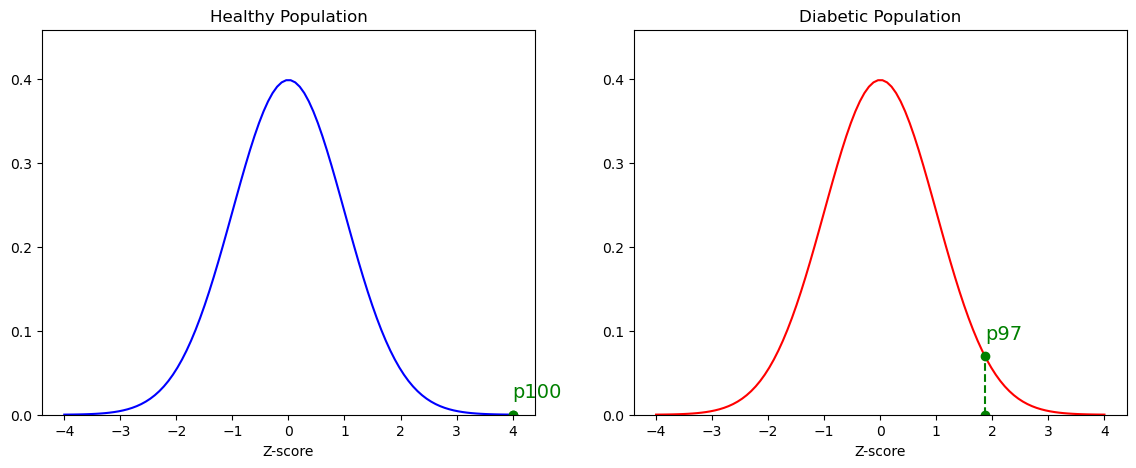

**************************************************
Risk Assessment for NAFLD:
Actual: 91.18986110971701
NAFLD Score: 91.19
Lifestyle Score: 0.0
Healthy Percentile: 99.96th, Diseased Percentile: 92.83th
NAFLD Score Distributions:


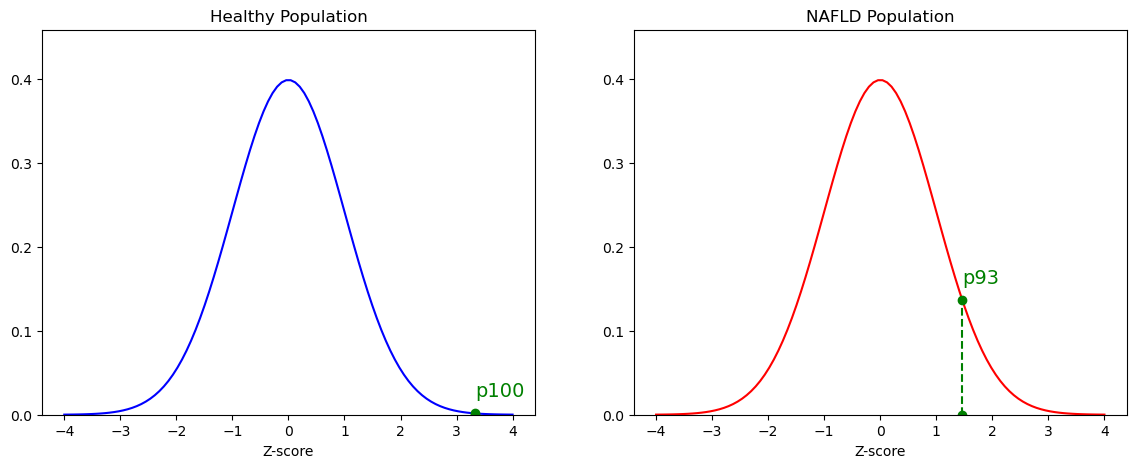

**************************************************
Risk Assessment for Cardiac Disease:
Actual: 100
Cardiac Score: 100.0
Healthy Percentile: 100.0th, Diseased Percentile: 98.91th
Cardiac Score Distributions:


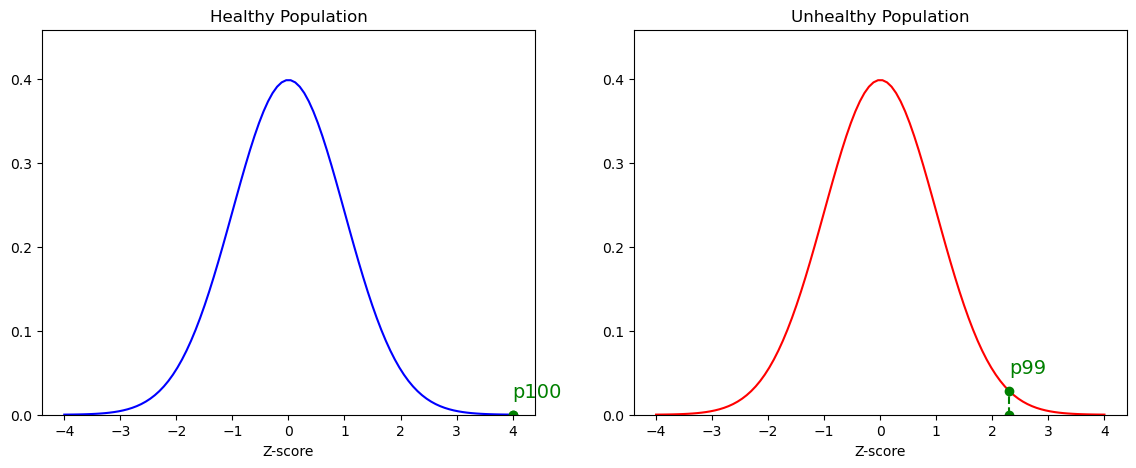

**************************************************
Risk Assessment for Hypertension:
Actual: 54.21650763482876
Hypertension Score: 54.22
Lifestyle Score: 10.53
Blood Pressure Distributions:


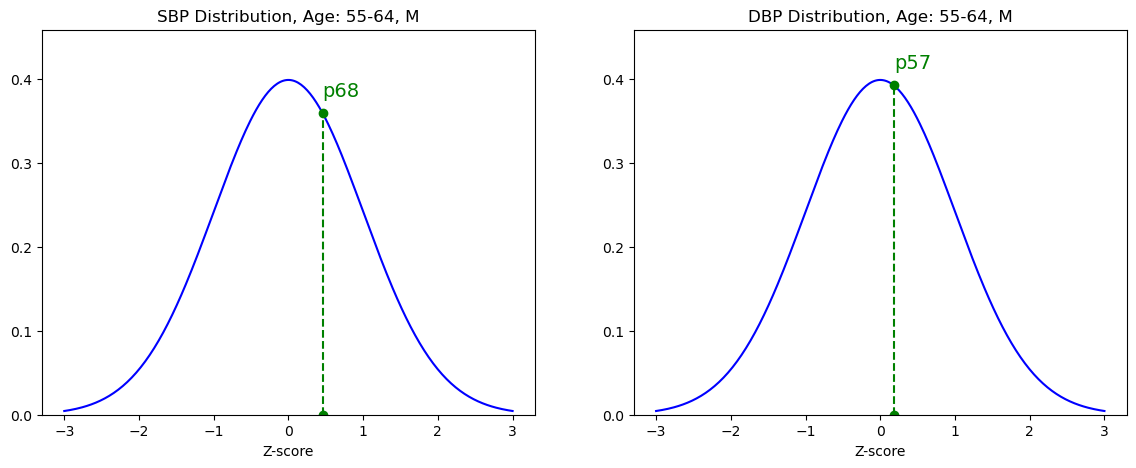

**************************************************
Risk Assessment for Dyslipidemia:
Actual: 100
Dyslipidemia Score: 100.0
Dyslipidemia Score Distributions:


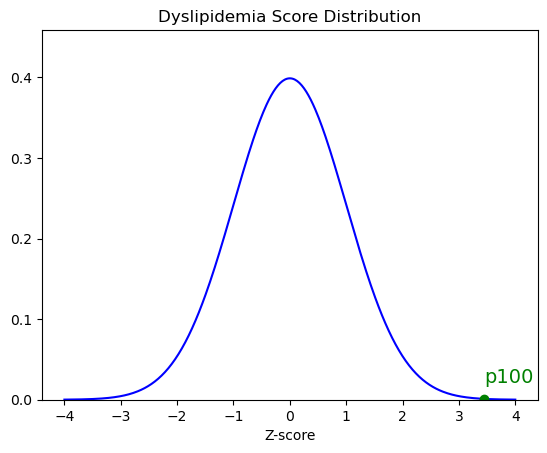

**************************************************
Risk Assessment for Hypothyroidism:
Actual: 94.09775544447564
Hypothyroidism Score: 94.1
TSH Level Distributions:


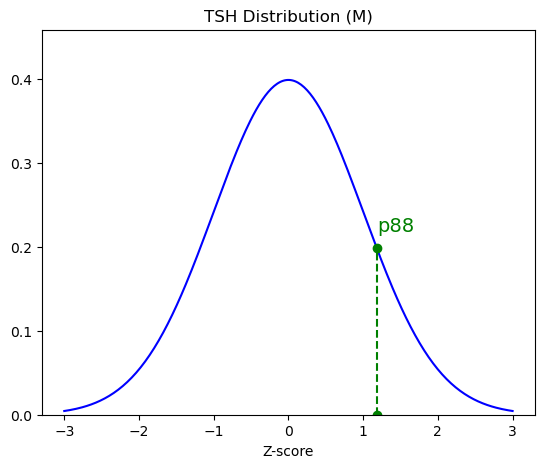

*******************************************************************************************************************
************************************************** End Of Report **************************************************
*******************************************************************************************************************


In [52]:
generate_comprehensive_report(P_II_14, questions)

In [53]:
P_I_17 = {
    'id' : 'I-17',
    'sex' :'F',
    'age' : 49,
    'WC': 78,
    'HC' : 95,
    'SBP': 132,
    'DBP': 80,
    'height': 149.2,
    'weight': 68.6,
    'BMI': 30.82,
    'TC': 246,
    'HDL': 42.8,
    'LDL': 186,
    'TG': 220,
    'VLDL': 44,
    'AST': 14,
    'ALT': 24,
    'GGT': 29,
    'glucose': 134,
    'PPBS': 202,
    'insulin': 15,
    'Uric_acid': 5.88,
    'TSH': 12.92,
    'T': 84,
    'LH': 18.79,
    'FSH': 5.65,
    'smoking': 0,
    'antihypertension_drugs':0,
    'platelets':100,
    'WBC':7,
    'monocytes':6.71
}

Patient Details:


,Values
id,I-17
sex,F
age,49
WC,78
HC,95
SBP,132
DBP,80
height,149.2
weight,68.6
BMI,30.82


**************************************************
Evaluating LifeStyle Scores, Please answer the following questions:
Good quality sleep
A) Between 7 to 9 hours per night
B) Between 5 to 6 hours per night
C) ≤4 or ≥9 hours per night
Your choice: a
Sedentary time
A) <1 hour per day
B) ≥1 and <4 hours per day
C) >4 hours per day
Your choice: a
Diet diversity
A) >3 food groups per day
B) < 3 food groups per day
Your choice: a
Physical activity
A) ≥60 mins per day
B) ≥30 mins per day
C) <30 mins or none per day
Your choice: a
Fruit intake
A) 1-2 per day
B) ≤2 to 3 times a week
C) Once a week or less
Your choice: a
Legume consumption
A) Everyday
B) Every alternate day
C) Not Frequent
Your choice: a
Alcohol consumption
A) <3 units/ week
B) ≥3 units / week
C) Former drinker
D) Do not drink
Your choice: a
Cigarette consumption
A) ≤2 days a month
B) ≥3 and ≤19 days a month
C) ≥20 days a month
D) Former smoker
E) Do not smoke
Your choice: a
Sugary drinks or beverages
A) ≤1 per week
B) 2-3 per w

,Marked Choice
Good quality sleep,A) Between 7 to 9 hours per night
Sedentary time,A) <1 hour per day
Diet diversity,A) >3 food groups per day
Physical activity,A) ≥60 mins per day
Fruit intake,A) 1-2 per day
Legume consumption,A) Everyday
Alcohol consumption,A) <3 units/ week
Cigarette consumption,A) ≤2 days a month
Sugary drinks or beverages,A) ≤1 per week
Breakfast frequency,A) More than 5 times a week


**************************************************
**************************************************
Comprehensive Report
Risk Assessment for Obesity:
Actual: 31.048887885288472
Obesity Score: 53.42
Lifestyle Score: 0.0
Healthy Percentile: 93.1, Diseased Percentile: 42.53
Obesity Score Distributions:


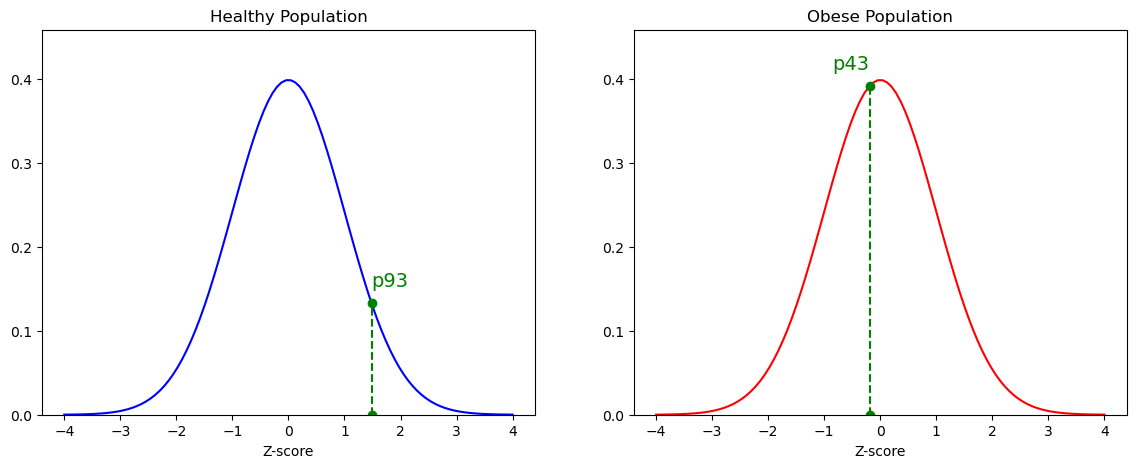

**************************************************
Risk Assessment for Metabolic Syndrome:
Actual: 40.75264962564908
Metabolic Syndrome Score: 76.11
Lifestyle Score: 25.0
Healthy Percentile: 100.0th, Diseased Percentile: 66.84th
Metabolic Syndrome Score Distributions:


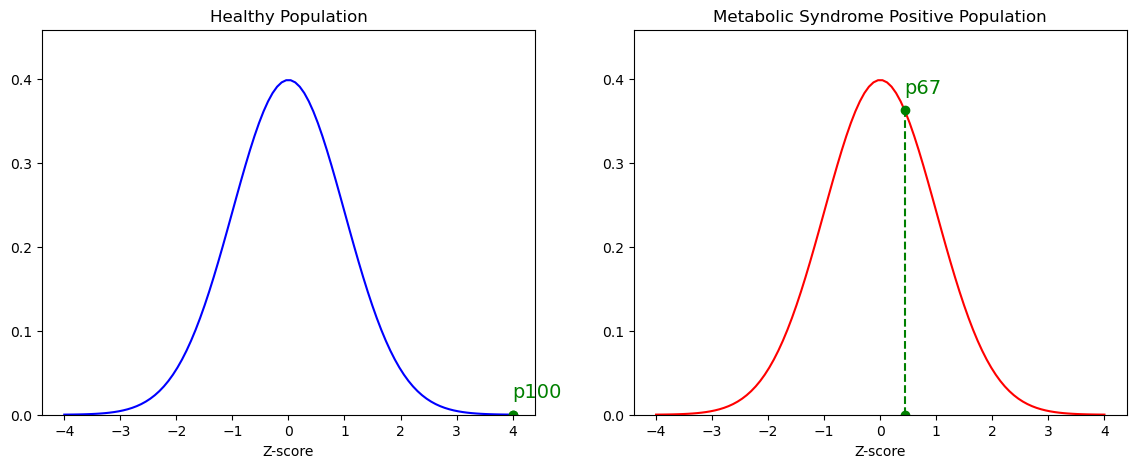

**************************************************
Risk Assessment for Diabetes I:
Actual: 51.53733848450667
Diabetes1 Score: 70.6
Lifestyle Score: 0.0
Healthy Percentile: 100.0th, Diseased Percentile: 61.32th
Diabetes(Type I) Score Distributions:


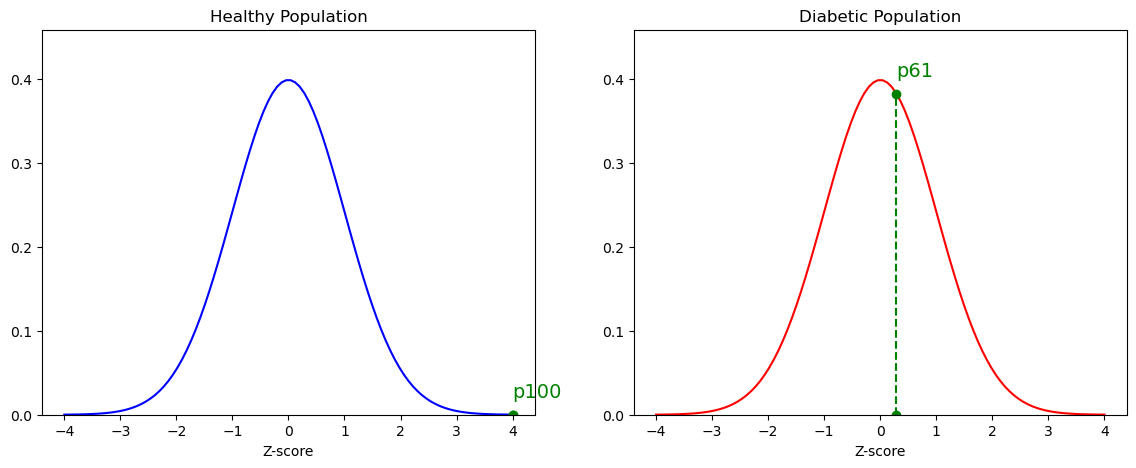

**************************************************
Risk Assessment for NAFLD:
Actual: 71.08853372436482
NAFLD Score: 70.56
Lifestyle Score: 0.0
Healthy Percentile: 98.74th, Diseased Percentile: 69.26th
NAFLD Score Distributions:


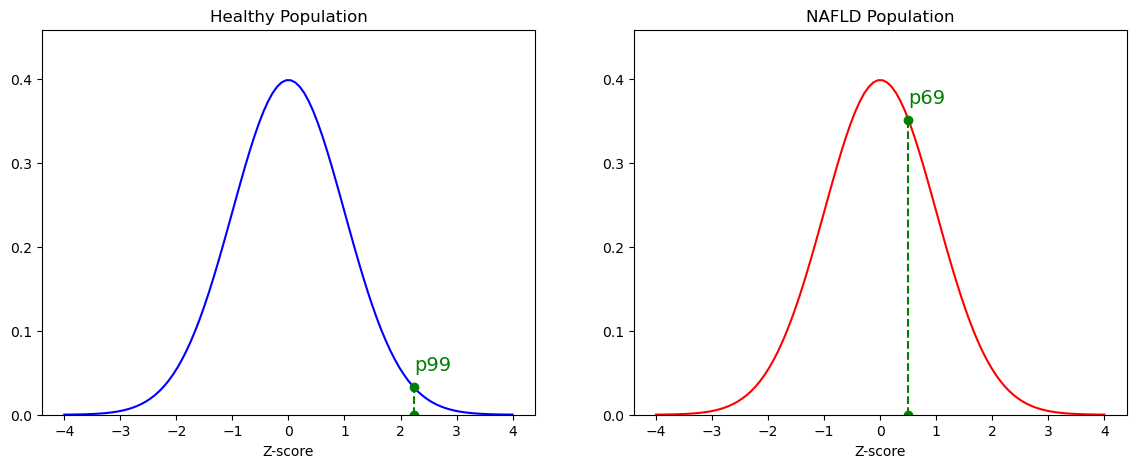

**************************************************
Risk Assessment for Cardiac Disease:
Actual: 57.53471240271745
Cardiac Score: 61.67
Healthy Percentile: 99.53th, Diseased Percentile: 49.03th
Cardiac Score Distributions:


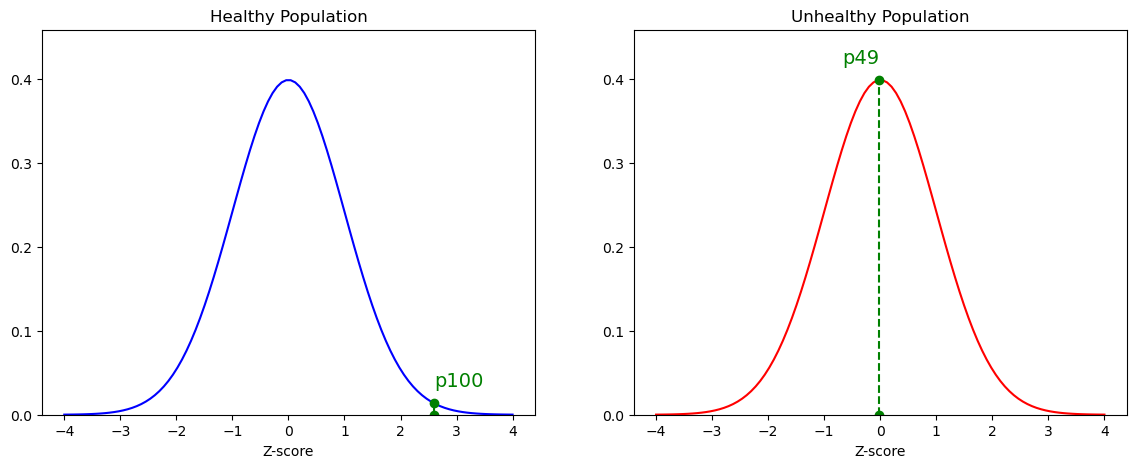

**************************************************
Risk Assessment for PCOD:
4.958 3.3256637168141587 84
Actual: 93.6929411457939
PCOD Score: 90.73
Healthy Percentile: 100.0th, Diseased Percentile: 87.39th
PCOD score Distributions:
4.958 3.3256637168141587 84


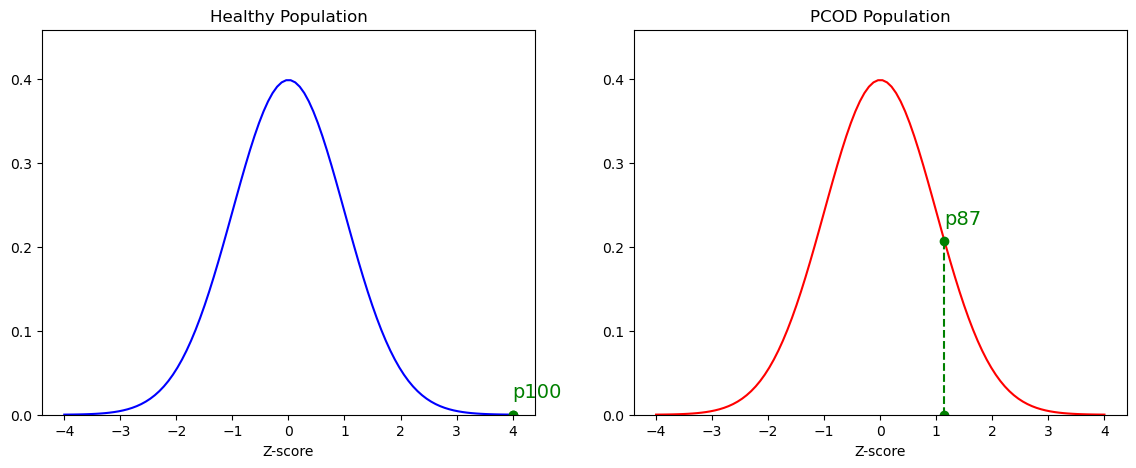

**************************************************
Risk Assessment for Hypertension:
Actual: 33.5177396757577
Hypertension Score: 33.52
Lifestyle Score: 10.53
Blood Pressure Distributions:


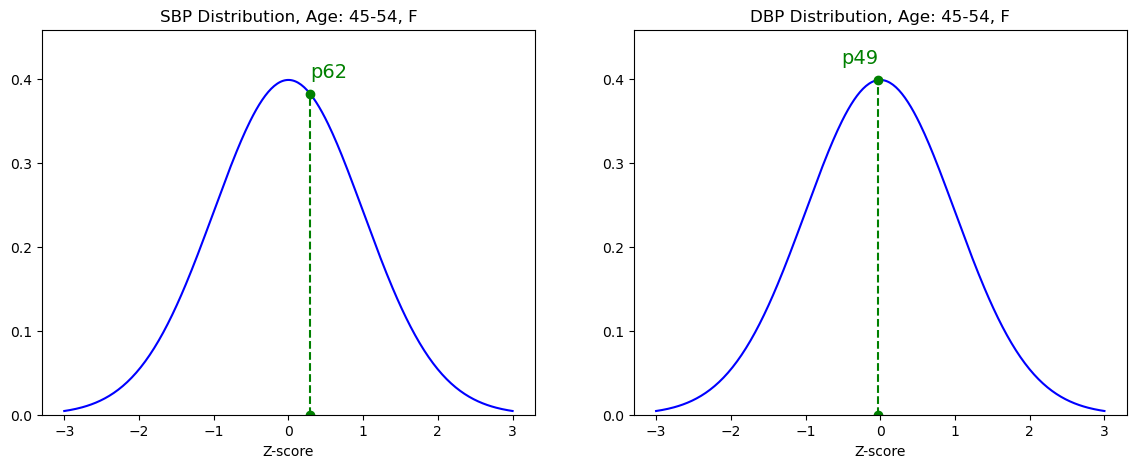

**************************************************
Risk Assessment for Dyslipidemia:
Actual: 86.13251700737989
Dyslipidemia Score: 93.69
Dyslipidemia Score Distributions:


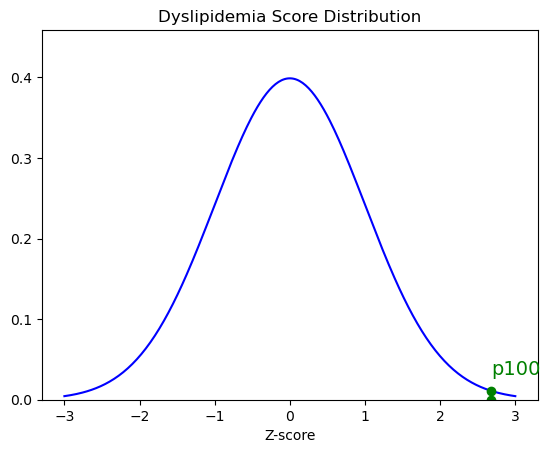

**************************************************
Risk Assessment for Hypothyroidism:
Actual: 51.07863627172923
Hypothyroidism Score: 51.08
TSH Level Distributions:


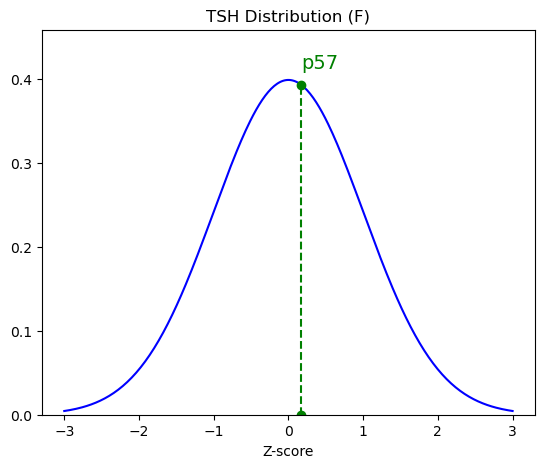

*******************************************************************************************************************
************************************************** End Of Report **************************************************
*******************************************************************************************************************


In [54]:
generate_comprehensive_report(P_I_17, questions)